# _Test on MNIST_

In [2]:
import numpy as np
from keras.datasets import mnist
from keras.utils import np_utils
import pandas as pd
import csv
import matplotlib.pyplot as plt
from progressbar import ProgressBar
import matplotlib.pyplot as plt
import pickle

In [3]:
%run CNN_class.py

In [4]:
class Network:
    '''
    The aim of this class is :
    - define the architecture of the neural network
    - create a method to simply train it from a training set
    - define a method to predict the class of any new image by calling the forward_prop method
    
    The get_weight and upload_weight might be useful to keep a trace of the state of the network at a certain moment of the training process.
    '''
    def __init__(self, image_shape, number_class, conv_shape, dense_shape):
        self.image_shape = image_shape #[depth,high,width]
        self.number_class = number_class
        self.conv_shape = conv_shape         #conv_shape is [[kernel_size, layer_size, input_depth] for l in 0:Nl]   
        self.dense_shape = dense_shape
        self.ce = []
        
    def net_init(self):
        self.Conv1 = ConvLayer(kernel_size = self.conv_shape[0][0], layer_size = self.conv_shape[0][1], input_depth = self.conv_shape[0][2])       
        self.fm_shape1 = [self.conv_shape[0][1], self.image_shape[1] - (self.Conv1.kernel_size[0]-1), self.image_shape[1] - (self.Conv1.kernel_size[1]-1)]
        self.Relu1 = relu(self.fm_shape1)
        self.Maxpool1 = maxpool(poolsize=2)
        self.fm_shape2 = [self.fm_shape1[0], self.fm_shape1[1] - (self.Maxpool1.poolsize-1), self.fm_shape1[2] - (self.Maxpool1.poolsize-1)]
        
        self.Conv2 = ConvLayer(kernel_size = self.conv_shape[1][0], layer_size = self.conv_shape[1][1], input_depth = self.conv_shape[1][2])
        self.fm_shape3 = [self.conv_shape[1][1], self.fm_shape2[1] - (self.Conv2.kernel_size[0]-1), self.fm_shape2[2] - (self.Conv2.kernel_size[1]-1)]
        self.Relu2 = relu(self.fm_shape3)
        
        self.Flatten1 = flatten(self.fm_shape3)
        
        self.Dense1 = Dense(self.dense_shape[0],np.product(self.fm_shape3))
        
        self.Dense2 = Dense(self.dense_shape[1],self.dense_shape[0])
        
        self.Dense3 = Dense(self.dense_shape[2],self.dense_shape[1])

        self.Softmax = softmaxlayer(self.dense_shape[1])
        
    def forward_prop(self, image):
        output1 = self.Conv1.forward_prop(image)
        #print('outputshape1 :' ,output1.shape)
        output2 = self.Relu1.forward_prop(output1)
        #print('outputshape2 :' ,output2.shape)
        output3 = self.Maxpool1.forward_prop(output2)
        #print('outputshape3 :' ,output3.shape)
        output4 = self.Conv2.forward_prop(output3)
        #print('outputshape4 :' ,output4.shape)
        output5 = self.Relu2.forward_prop(output4)
        #print('outputshape5 :' ,output5.shape)
        output6 = self.Flatten1.forward_prop(output5)
        #print('outputshape6 :' ,output6.shape)
        output7 = self.Dense1.forward_prop(output6)
        #print('outputshape7 :' ,output7.shape)
        output8 = self.Dense2.forward_prop(output7)
        #print('outputshape8 :' ,output8.shape)
        output9 = self.Dense3.forward_prop(output8)
        #print('outputshape9 :' ,output9.shape)
        output10 = self.Softmax.forward_prop(output9)
        self.lastoutput = output10 
        return None
    
    def back_prop(self,target,learning_rate = 0.01):
        self.ce.append(self.Softmax.cross_entropy(self.lastoutput, target, epsilon = 1e-12))
        
        self.learning_rate = learning_rate
        
        output1 = self.Softmax.back_prop(target)
        self.output1 = output1
        #print(1)
        output2 = self.Dense3.back_prop(output1, self.learning_rate)
        self.output2 = output2
        #print(2)
        output3 = self.Dense2.back_prop(output2, self.learning_rate)
        self.output3 = output3
        #print(3)
        output4 = self.Dense1.back_prop(output3,self.learning_rate)
        self.output4 = output4
        #print(4)
        output5 = self.Flatten1.back_prop(output4)
        self.output5 = output5
        #print(5)
        output6 = self.Relu2.back_prop(output5)
        self.output6 = output6
        #print(6)
        output7 = self.Conv2.back_prop(output6,self.learning_rate)
        self.output7 = output7
        #print(7)
        output8 = self.Maxpool1.back_prop(output7)
        self.output8 = output8
        #print(8)
        output9 = self.Relu1.back_prop(output8)
        self.output9 = output9
        #print(9)
        output10 = self.Conv1.back_prop(output9,self.learning_rate)
        self.output10 = output10
        return None
    
    def train(self,epochs,X_train,y_train,learning_rate = 0.01):
        order = np.array(range(len(X_train)))
        np.random.shuffle(order)
        self.learning_rate = learning_rate
        K = (1/epochs) * np.log(2)
        self.success_rate = []
        for epoch in range(epochs):
            pbar = ProgressBar()
            self.predictions = []
            self.success_pred = []
            learning_rate = self.learning_rate * np.exp(-K*epoch)
            for i in pbar(order):
                self.forward_prop(X_train[i])
                self.predictions.append(np.where(self.lastoutput == np.amax(self.lastoutput))[0][0])
                self.back_prop(y_train[i],learning_rate)
                self.success_pred.append(self.predictions[-1] == np.where(y_train[i] == 1)[0][0])
            self.success_rate.append(np.mean(self.success_pred))
            print('The accuracy for this epoch is : ',self.success_rate[-1]*100,'%')
        return None
        
    def get_weights(self):
        weights = []
        weights.append(self.Conv1.filters)
        weights.append(self.Conv2.filters)
        weights.append([self.Dense1.weights,self.Dense1.biases])
        weights.append([self.Dense2.weights,self.Dense2.biases])
        weights.append([self.Dense3.weights,self.Dense3.biases])
        return weights
    
    def upload_weights(self,weights):
        self.Conv1.filters = weights[0]
        self.Conv2.filters = weights[1]
        self.Dense1.weights = weights[2][0]
        self.Dense1.biases = weights[2][1]
        self.Dense2.weights = weights[3][0]
        self.Dense2.biases = weights[3][1]
        self.Dense3.weights = weights[4][0]
        self.Dense3.biases = weights[4][1]
        return None
    
    def prediction(self, image):
        self.forward_prop(image)
        output_sm = self.lastoutput
        pred = np.where(output_sm == np.amax(output_sm))[0][0]
        return pred
    
    

## Network architecture:


We define the network with the following architecture:
- A first Convolution layer with __8 kernels of size 3 by 3__ and a __ReLU__ activation function
- A __MaxPool__ layer
- A second Convolution layer with __16 kernels of size 3 by 3__ and a __ReLU__ activation function
- A __Flatten__ Layer 
- A first Dense layer with __64 neurons__ with a __ReLU__ activation function
- A first Dense layer with __32 neurons__ with a __ReLU__ activation function
- A first Dense layer with __10 neurons__ with a __ReLU__ activation function
- A __Softmax__ layer

In [5]:
conv_shape = [[[3,3],8,1],[[3,3],16,8]]
dense_shape = [64,32,10]

In [6]:
net = Network(image_shape = [1,28,28],number_class = 10,conv_shape = conv_shape, dense_shape= dense_shape)

In [7]:
net.net_init()

In [8]:
#extraction and preparation of the training and test set from MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train[:,np.newaxis,:,:]
X_test = X_test[:,np.newaxis,:,:]
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)
X_train = X_train/255
X_test = X_test/255

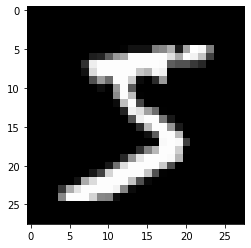

In [9]:
#exemple of data from MNIST
plt.imshow(X_train[0][0], cmap='gray')
plt.show()

In [10]:
X_train = X_train[0:400]
y_train = y_train[0:400]

In [12]:
net.train(20,X_train,y_train)

100% |########################################################################|


The accuracy for this epoch is :  32.5 %


100% |########################################################################|


The accuracy for this epoch is :  55.50000000000001 %


100% |########################################################################|


The accuracy for this epoch is :  76.0 %


100% |########################################################################|


The accuracy for this epoch is :  84.0 %


100% |########################################################################|


The accuracy for this epoch is :  88.5 %


100% |########################################################################|


The accuracy for this epoch is :  95.5 %


100% |########################################################################|


The accuracy for this epoch is :  97.5 %


100% |########################################################################|


The accuracy for this epoch is :  99.0 %


100% |########################################################################|


The accuracy for this epoch is :  100.0 %


100% |########################################################################|


The accuracy for this epoch is :  100.0 %


100% |########################################################################|


The accuracy for this epoch is :  100.0 %


100% |########################################################################|


The accuracy for this epoch is :  100.0 %


100% |########################################################################|


The accuracy for this epoch is :  100.0 %


100% |########################################################################|


The accuracy for this epoch is :  100.0 %


100% |########################################################################|


The accuracy for this epoch is :  100.0 %


100% |########################################################################|


The accuracy for this epoch is :  100.0 %


100% |########################################################################|


The accuracy for this epoch is :  100.0 %


100% |########################################################################|


The accuracy for this epoch is :  100.0 %


100% |########################################################################|


The accuracy for this epoch is :  100.0 %


The accuracy for this epoch is :  100.0 %


In [ ]:
#save the weights
with open("weights.txt", "wb") as fp:
    pickle.dump(l, fp)

In [11]:
#To upload the weights of the network trained:
with open("weights.txt", "rb") as fp:
    weights = pickle.load(fp)
net.upload_weights(weights)

<function matplotlib.pyplot.show(*args, **kw)>

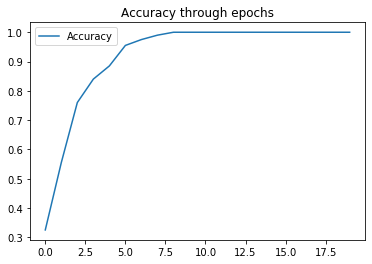

In [13]:
plt.plot(range(len(net.success_rate)),net.success_rate)
plt.title('Accuracy through epochs')
plt.legend(['Accuracy'])
plt.show

After a training on 20 epochs composed of 400 elements from MNIST, we obtain an accuracy of 100% (The accuracy is actually 100% from the epoch 10, 20 epochs was maybe not necessary).<br>
Considering the fact that we didn't use neither dropout layer, nor BatchNormalization, and that we took a small sampel of the whole dataset (in order to get a solution faster) there might be quit some overfitting on the training set. <br>
It is thus interesting to see how our network perform on a test set:

## Accuracy on a test set

In [14]:
X_test = X_test[0:500]
y_test = y_test[0:500]

In [15]:
pred_success = []
pbar = ProgressBar()
for i in pbar(range(500)):
    pred_success = net.prediction(X_test[i]) == np.where(y_test[i] == 1)[0][0]
print('The mean accuracy on the test set is : ', np.mean(pred_success)*100,'%')

The mean accuracy on the test set is :  100.0 %


The accuracy on the test set is quit good though: none of the 500 images in the test set were misclassified.

## Possible improvement :

- Add BatchNormalization and Dropout layers
- Add an optimize such as Adam
- work on the whole dataset
- save gradients though back propagations in order to add the option to do mini-Batch gradient descent instead of SGD